In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch 
codes = pd.read_csv("dataset/codes.csv")


def snomedConvert(code,snomed=True):
    codes = pd.read_csv("dataset/codes.csv")[["Dx","SNOMED CT Code"]]
    
    if snomed:
        df.columns = [codes[codes["SNOMED CT Code"] == x].iloc[0]["Dx"] for x in df.columns]
        return df

In [2]:
df = pd.read_csv("dataset/WFDB_Ga.csv")
df

,6374002,11157007,17338001,27885002,39732003,47665007,49578007,55930002,59118001,59931005,...,429622005,445118002,445211001,698252002,713422000,713426002,713427006,67741000119109,headers,leads
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00001.hea,dataset/WFDB_Ga/E00001.mat
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00002.hea,dataset/WFDB_Ga/E00002.mat
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00003.hea,dataset/WFDB_Ga/E00003.mat
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00004.hea,dataset/WFDB_Ga/E00004.mat
4,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00005.hea,dataset/WFDB_Ga/E00005.mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10339,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E10340.hea,dataset/WFDB_Ga/E10340.mat
10340,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E10341.hea,dataset/WFDB_Ga/E10341.mat
10341,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E10342.hea,dataset/WFDB_Ga/E10342.mat
10342,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,dataset/WFDB_Ga/E10343.hea,dataset/WFDB_Ga/E10343.mat


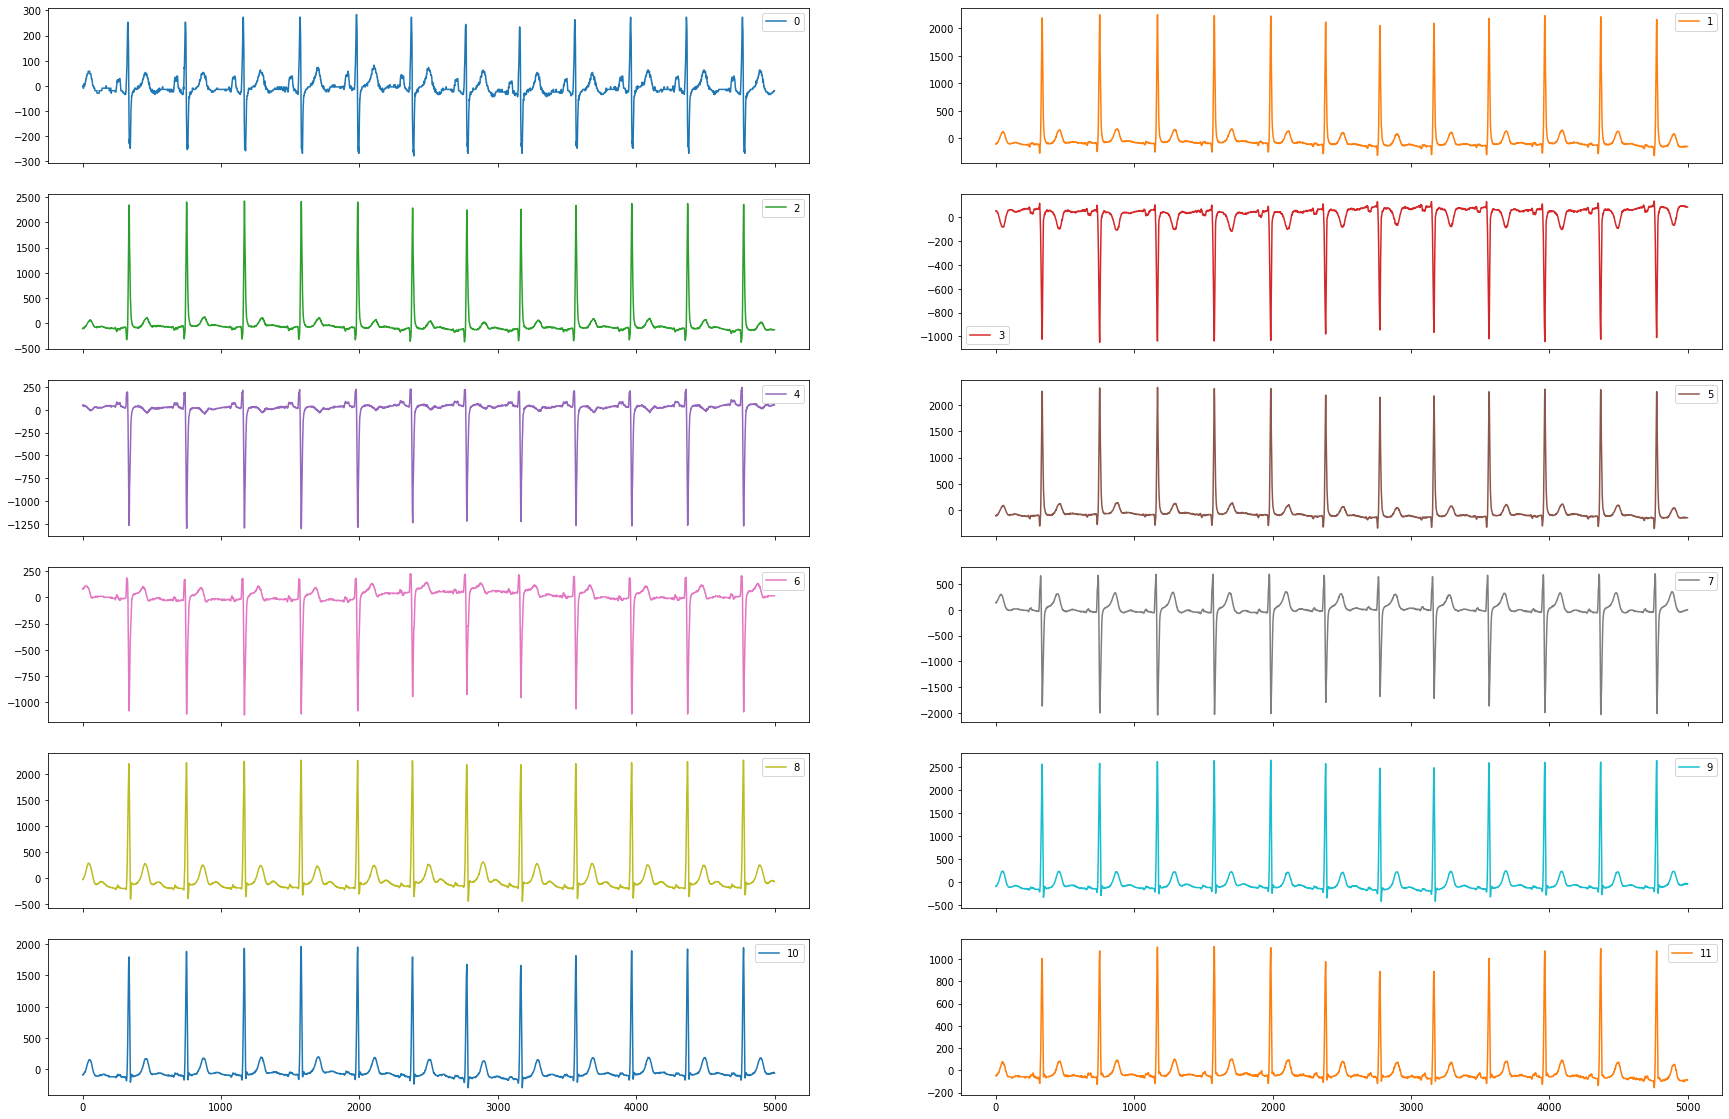

In [3]:
leads = load_recording(df["leads"][1000])
# print(leads.shape)
fig = pd.DataFrame(leads).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

In [4]:
# ecg dataloder
class ECG_Dataset(Dataset):

    def __init__(self, df, length = 2500, transform=None):
        self.ecg_df = df
        self.transform = transform
        self.max_length = length
    def __len__(self):
        return len(self.ecg_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.ecg_df.iloc[idx]
        try: 
            enp = load_recording(row["leads"])[:,0:self.max_length]
        except Exception as e:
                print(e)
                enp = np.zeros([12,self.max_length])
                pass
        enp = np.nan_to_num(enp,0) # prevent nans from occuring

        sample = {
#                     "idx":idx_num,
                "leads":row["leads"],
                "headers":row["headers"],
                "labels": list(row.drop(labels=["leads","headers"]).keys()),
                "y": list(row.drop(labels=["leads","headers"]).to_numpy()),
                'leads': enp,
#                 "nsamples": row["nsamples"],
#                 "duration": row["duration"],
                }

        if self.transform:
            sample = self.transform(sample)

        return sample

train_val, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train_val, test_size=0.2)
train_loader = DataLoader(ECG_Dataset(train), batch_size=4,
                        shuffle=True, ) 
test_loader = DataLoader(ECG_Dataset(test), batch_size=32,
                        shuffle=True, ) 
# val_loader = DataLoader(ECG_Dataset(val), batch_size=32,
#                         shuffle=True, ) 


# Load memmap

In [ ]:
from helper_code import *
from team_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
directories = glob("dataset/*/", recursive = True)
d = directories[0]
dataset = d.split("/")[-2]
header_files, recording_files = find_challenge_files(d)
num_recordings = len(recording_files)

if not num_recordings:
    raise Exception('No data was provided.')

# Extract the classes from the dataset.

classes = set()
for header_file in header_files:
    header = load_header(header_file)
    classes |= set(get_labels(header))
if all(is_integer(x) for x in classes):
    classes = sorted(classes, key=lambda x: int(x)) # Sort classes numerically if numbers.
else:
    classes = sorted(classes) # Sort classes alphanumerically if not numbers.
num_classes = len(classes)

# Extract the features and labels from the dataset.

print('Extracting features and labels for %s'%dataset)
print("\n")
data = np.zeros((num_recordings, 14), dtype=np.float32) # 14 features: one feature for each lead, one feature for age, and one feature for sex
labels = np.zeros((num_recordings, num_classes), dtype=np.bool_) # One-hot encoding of classes
label_names = []
for i in range(num_recordings):
    print('    {}/{}...'.format(i+1, num_recordings),end="\r")

    # Load header and recording.
    header = load_header(header_files[i])
    recording = load_recording(recording_files[i])

    # Get age, sex and root mean square of the leads.
    age, sex, rms = get_features(header, recording, twelve_leads)
    data[i, 0:12] = rms
    data[i, 12] = age
    data[i, 13] = sex

    current_labels = get_labels(header)
    label_names.append(current_labels[0])
    for label in current_labels:
        if label in classes:
            j = classes.index(label)
            labels[i, j] = 1


In [ ]:
leads = [load_recording(r)[:,0:2500] for r in recording_files]
X =  np.array(leads)[0:400].astype(np.float32)
y = np.array([l for l in label_names])[0:400]

# apply a model

In [22]:
from tsai.all import *
import torch
computer_setup()

os             : Linux-4.15.0-70-generic-x86_64-with-glibc2.10
python         : 3.8.5
tsai           : 0.2.24
fastai         : 2.5.3
fastcore       : 1.3.27
torch          : 1.8.1+cu101
n_cpus         : 96
device         : cuda (Tesla V100-SXM2-32GB)


In [23]:
X = np.load('./dataset/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
df = pd.read_csv("dataset/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(df)
y = y[y.columns[0]].to_numpy()
y

array([ True, False, False, ..., False, False, False])

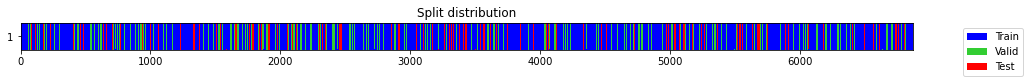

((#4815) [2849,6802,4096,496,2012,173,1178,5343,505,5739...],
 (#1375) [4964,5847,413,6628,1735,5258,6065,3308,3619,3857...],
 (#687) [2626,5678,5053,2717,3363,963,5856,5471,1253,148...])

In [24]:
splits = get_splits(y, valid_size=.2,test_size=0.1, stratify=True, random_state=23, shuffle=True)
splits

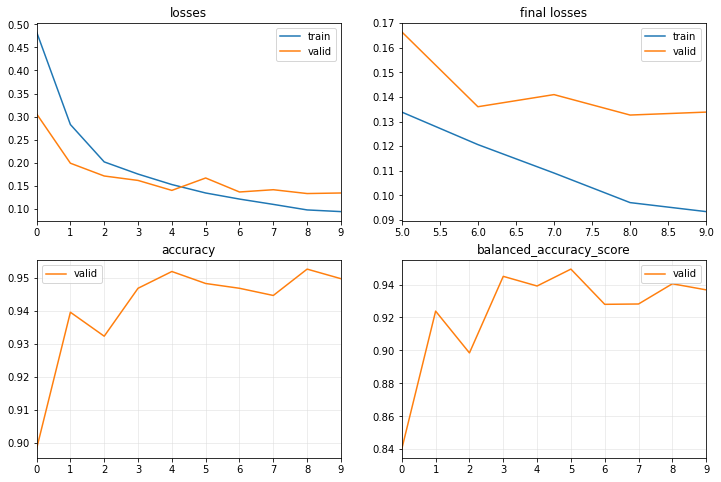

In [25]:
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)

model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=[accuracy, BalancedAccuracy()], cbs=PredictionDynamics())
learn.fit_one_cycle(10, lr_max=1e-4)
learn.recorder.plot_metrics()

In [12]:
# learn.show_results(sharey=True)

In [ ]:
model = build_ts_model(MiniRocketHead, dls=dls)
learn = ts_learner(dls, model, metrics=[accuracy, BalancedAccuracy()], cbs=PredictionDynamics())

timer.start()
learn.fit_one_cycle(10, 1e-4)
timer.stop()

In [ ]:
# learn.show_results(sharey=True)

In [141]:
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True), TSMagScale(), TSWindowWarp()]
# batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X.astype(float), y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
model = build_ts_model(MiniRocket, dls=dls)
learn = Learner(dls, model, metrics=[accuracy, BalancedAccuracy()], cbs=PredictionDynamics())
learn.fit_one_cycle(10, lr_max=3e-4)
learn.recorder.plot_metrics()

TypeError: __init__() got an unexpected keyword argument 'custom_head'

# multilabel

In [60]:
df = pd.read_csv("dataset/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [142]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)

model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy_multi,loss_func=nn.BCEWithLogitsLoss(), cbs=ShowGraph())
learn.fit_one_cycle(10, lr_max=1e-4)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.633363,0.551760,0.831919,00:06
1,0.499285,0.420329,0.900525,00:06
2,0.386124,0.332753,0.903273,00:06
3,0.319371,0.286493,0.906263,00:06
4,0.281270,0.264443,0.911273,00:06
5,0.259445,0.251723,0.913374,00:06
6,0.244519,0.237787,0.917172,00:06
7,0.233947,0.233423,0.917737,00:06
8,0.230334,0.230604,0.918949,00:06
9,0.226735,0.230171,0.919192,00:06


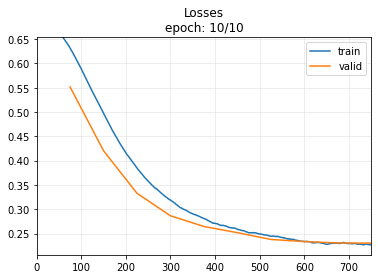

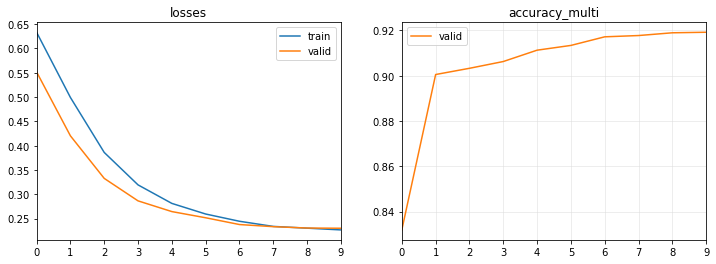

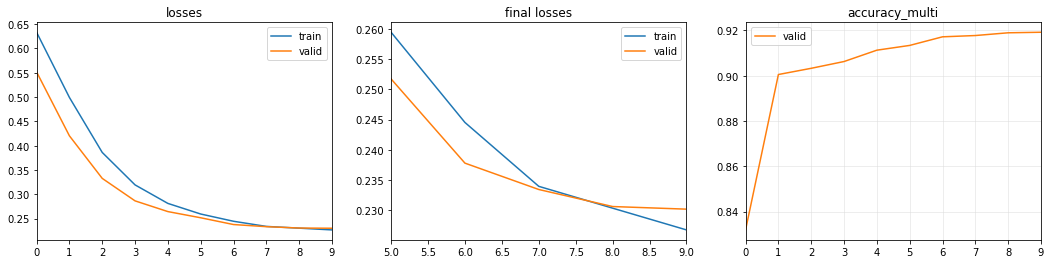

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.675920,0.657243,0.550303,0.592772,0.159070,0.648480,0.537063,0.255435,00:06
1,0.642234,0.618621,0.727515,0.637677,0.223082,0.519702,0.755651,0.311993,00:06
2,0.608368,0.583928,0.839596,0.638676,0.341343,0.374944,0.902407,0.356887,00:06
3,0.577003,0.555069,0.888000,0.620599,0.562403,0.269632,0.971567,0.363613,00:06
4,0.549399,0.529884,0.896404,0.604175,0.715933,0.220637,0.987713,0.335879,00:06
5,0.524806,0.507290,0.897939,0.591881,0.803697,0.190183,0.993580,0.306481,00:06
6,0.502608,0.486607,0.898343,0.587076,0.847568,0.178556,0.995596,0.294074,00:06
7,0.481999,0.468004,0.898909,0.586782,0.870896,0.177141,0.996422,0.293546,00:06
8,0.462613,0.448669,0.899071,0.586326,0.882072,0.175861,0.996790,0.292418,00:05
9,0.444670,0.431737,0.900121,0.592816,0.871172,0.189484,0.996148,0.310299,00:06


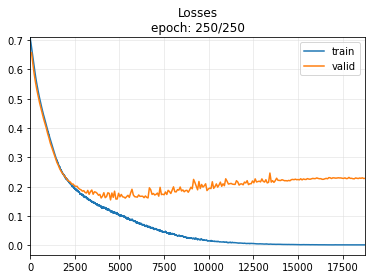

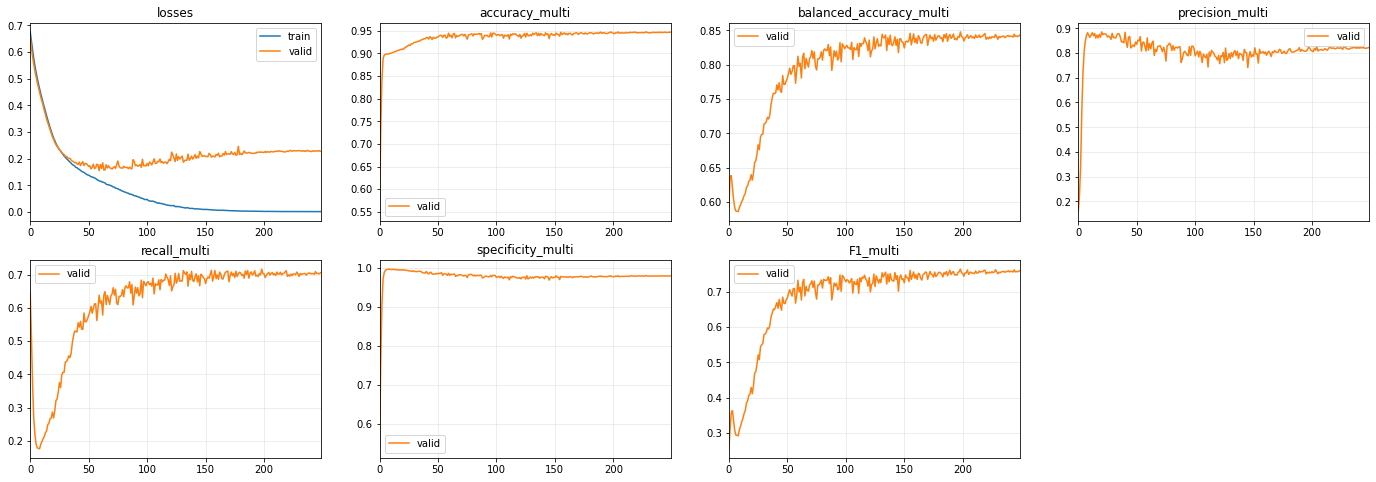

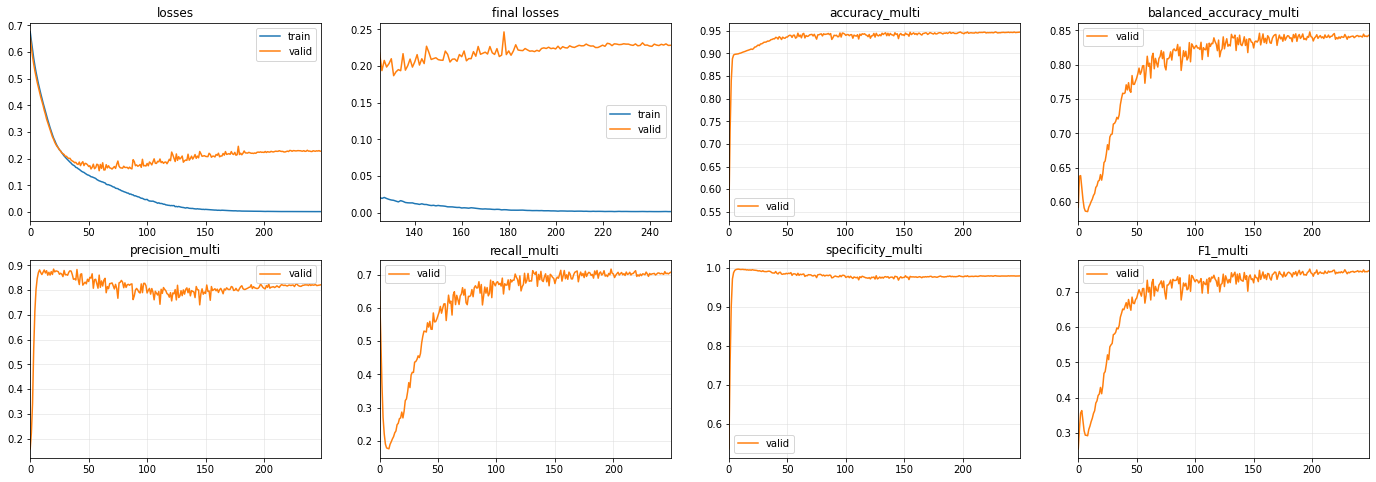

In [163]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=ShowGraph())
learn.fit_one_cycle(250, lr_max=1e-4)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.641063,0.622709,0.734545,0.517140,0.136715,0.231761,0.802520,0.171901,00:06
1,0.611511,0.589836,0.809374,0.549670,0.204747,0.208755,0.890586,0.206412,00:06
2,0.582167,0.560949,0.855192,0.571487,0.323437,0.199092,0.943882,0.245412,00:06
3,0.555004,0.533888,0.884525,0.590301,0.542633,0.204070,0.976532,0.294600,00:06
4,0.530924,0.520245,0.895596,0.597700,0.719151,0.206677,0.988723,0.319086,00:06
5,0.508454,0.495510,0.900606,0.604376,0.814572,0.215540,0.993213,0.339641,00:06
6,0.487649,0.470978,0.901899,0.606270,0.844370,0.218225,0.994314,0.345432,00:06
7,0.467874,0.452630,0.901576,0.605750,0.836863,0.217459,0.994040,0.343427,00:06
8,0.449604,0.434276,0.902303,0.604080,0.870022,0.212655,0.995505,0.340089,00:06
9,0.432827,0.419964,0.902141,0.601345,0.882333,0.206543,0.996147,0.333555,00:06


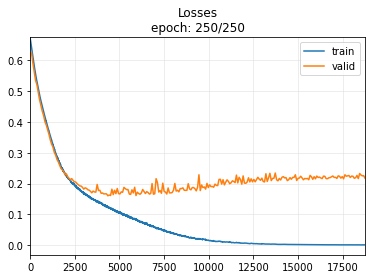

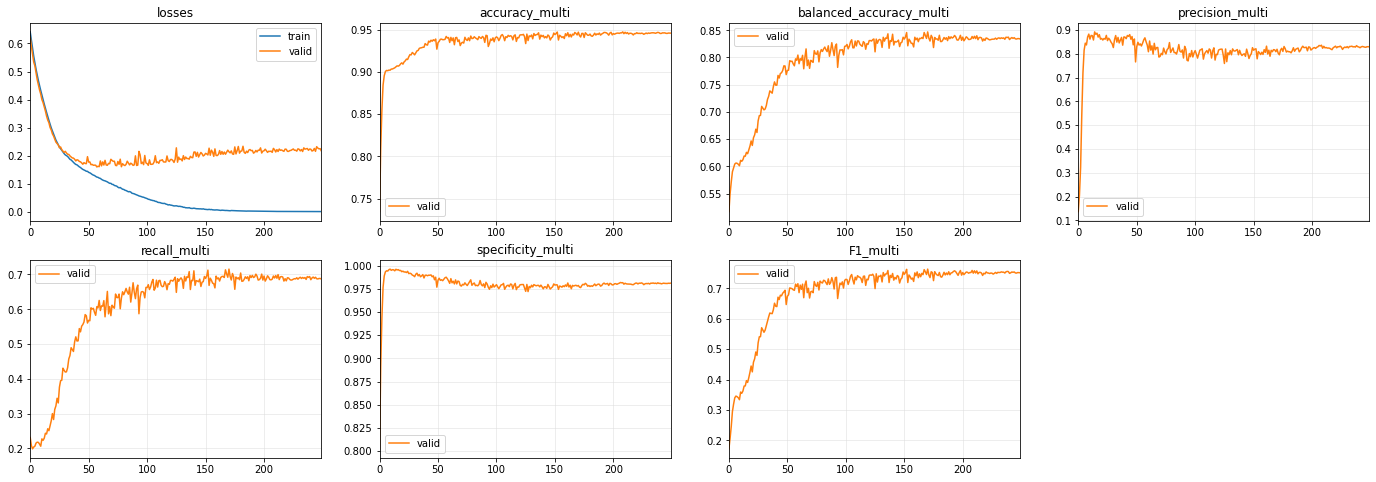

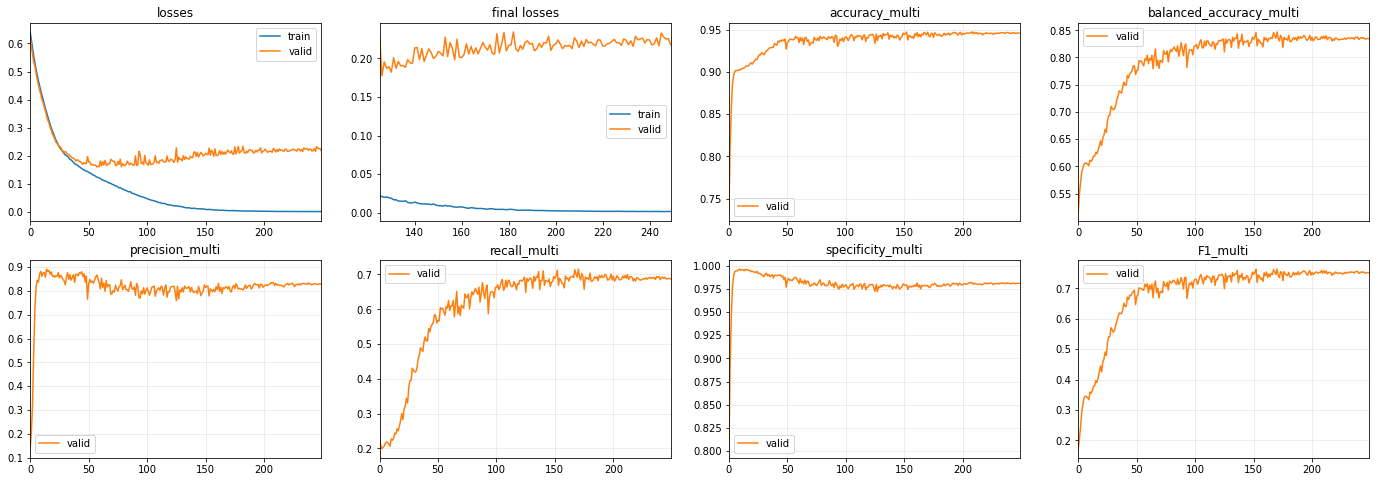

In [164]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True), TSMagScale()]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=ShowGraph())
learn.fit_one_cycle(250, lr_max=1e-4)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.692327,0.690091,0.591354,0.617137,0.174182,0.650902,0.583372,0.274794,00:22
1,0.685375,0.688492,0.591354,0.617137,0.174182,0.650902,0.583372,0.274794,00:22
2,0.678732,0.685903,0.591354,0.617137,0.174182,0.650902,0.583372,0.274794,00:21
3,0.672943,0.684019,0.591354,0.617137,0.174182,0.650902,0.583372,0.274794,00:22
4,0.667764,0.681875,0.591354,0.617137,0.174182,0.650902,0.583372,0.274794,00:21
5,0.663128,0.679836,0.591354,0.617137,0.174182,0.650902,0.583372,0.274794,00:22
6,0.658186,0.677223,0.760404,0.616406,0.228727,0.427368,0.805445,0.297936,00:22
7,0.653184,0.675297,0.811556,0.536439,0.187636,0.175339,0.897539,0.181251,00:22
8,0.648089,0.672538,0.811556,0.536439,0.187636,0.175339,0.897539,0.181251,00:22
9,0.642049,0.669194,0.811556,0.536439,0.187636,0.175339,0.897539,0.181251,00:23


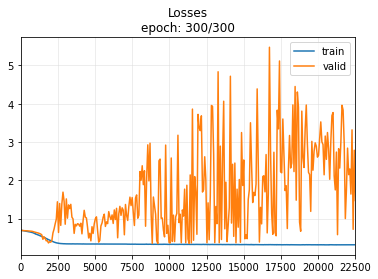

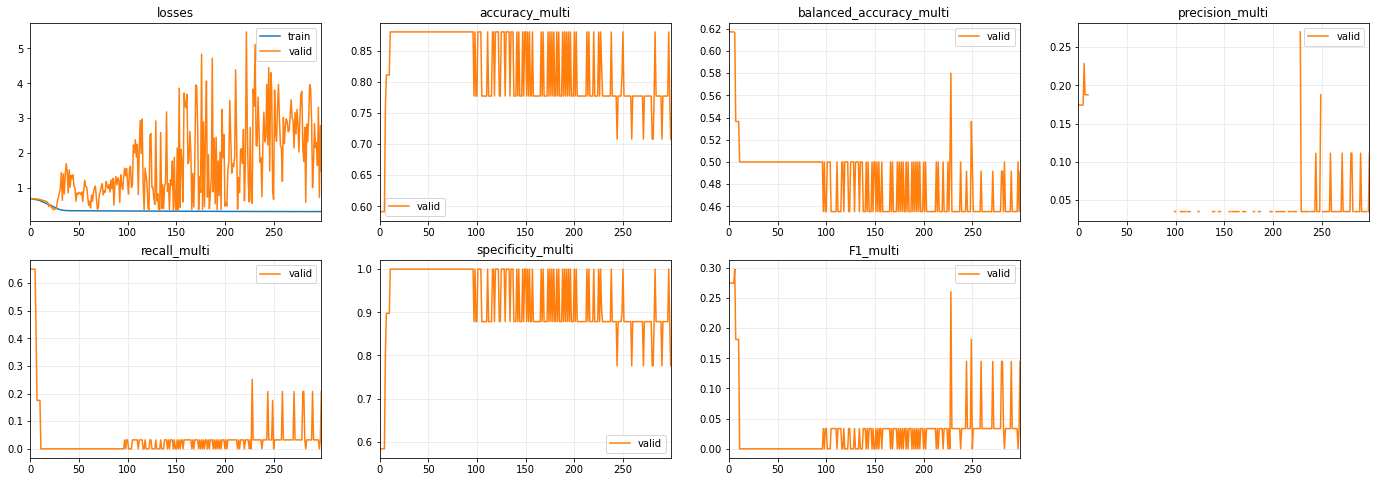

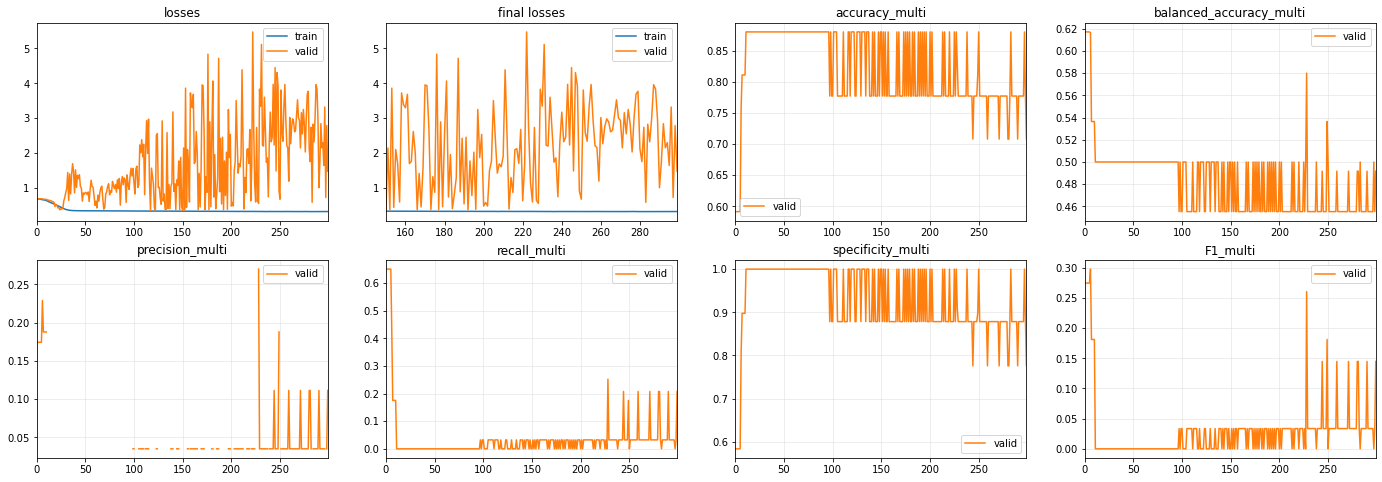

In [165]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True), TSMagScale(),TSWindowWarp()]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=ShowGraph())
learn.fit_one_cycle(300, lr_max=1e-4)
learn.recorder.plot_metrics()